<a href="https://colab.research.google.com/github/nim17/Flipkart-mobile-price-/blob/master/GPT2_distill_top5_words_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from os import listdir
mypath="/content/"
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#onlyfiles = [f for f in onlyfiles if f.split('.')[-1]=='htm']
onlyfiles

['topicfooter.htm',
 'useful_links.htm',
 'Company_Sick_Pay.htm',
 'Equal_Opportunities.htm',
 'topic_list.htm',
 'topicfooterDark.htm',
 'html5.png',
 'outputs_mobile_apps.htm',
 'variables.htm',
 'Dependants_Leave.htm',
 'Health_and_Safety.htm',
 'Disciplinary_Procedure.htm',
 'Bookings.htm',
 'dropdowns.htm',
 'scripts.htm',
 'contents_panel.htm',
 'snippets.htm',
 'outputs_ebook.htm',
 'outputs_xml.htm',
 'homepagefooterDark.htm',
 'resource_linking.htm',
 'skin_editor.htm',
 'toc.htm',
 'topic.htm',
 'upgrading_to_2019.htm',
 'browse_sequences.htm',
 'dynamic_content.htm',
 'Topic_One.htm',
 'master_pages.htm',
 'find_and_replace.htm',
 'reports.htm',
 'single_sourcing.htm',
 'outputs_frameless.htm',
 'command_line.htm',
 'outputs_pdf.htm',
 'glossary.htm',
 'homepagefooter.htm',
 'outputs_word.htm',
 'Attendance.htm',
 'outputs_general.htm',
 'robohelp_reimagined.htm',
 'New_Topic1.htm',
 'cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb',
 'index.htm',
 'Flexible_Working.htm',


In [9]:
path="/content/"

f=open(f'{path}Attendance.htm')
from bs4 import BeautifulSoup
"""soup=BeautifulSoup(text)
for hit in soup.findAll('body'):
    print (hit.text)"""
#print(text)
text_list=[]
i=0
for t in onlyfiles:
    p=path+t
   # print(p)
    f = open(f"{p}", "r")
    try:
        text=f.read()
        soup=BeautifulSoup(text)
        text=[hit.text for hit in soup.findAll('body')]
        text="".join(text)
        text_list.append(text)
    except UnicodeDecodeError:
        i+=1
        print(i)    
text_list[0]

1
2


'\n\n\n\n\nEN\n\n\n\n\n\nContact Us\n\n\nPrivacy Policy\n\n\nTerms and Conditions\n\n\nBlog\n\n\n\n'

In [0]:
def prep(text):
    esc=['\n','\r','\t','\b','\f','\ooo','\h',"\'"]
    text=text.replace("\n"," ")
    text=[t for t in text if t not in esc]
    text=''.join(text)
    text=" ".join(text.split())
    text=text.replace('Â ', '')
    text=text.split(".")[2:]
    text=". ".join(text)
    return text
text=[prep(t) for t in text_list]

In [11]:
text_list=text.copy()
len(text_list)

77

In [13]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelWithLMHead
import time
from matplotlib import pyplot as plt
import os
import psutil

total_matches=0
total_length=0
accuracy_list=[]
times_list=[]
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
# import logging
# logging.basicConfig(level=logging.INFO)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
# Load pre-trained model (weights)
model = AutoModelWithLMHead.from_pretrained("distilgpt2")
# Encode a text inputs
# text = "Who was Jim Henson? Jim Henson was a man"
# text = "Delete this text and replace it with your"
right_confidence=[]
wrong_confidence=[]
correct_words=[]
j=0
for t in text_list:
    text = t
    j+=1
    #if j==3:
    #  break
    indexed_tokens = tokenizer.encode(text)


    # Convert indexed tokens in a PyTorch tensor
    tokens_tensor = torch.tensor([indexed_tokens])
    input_tensor = tokens_tensor[:,:-1]
    output_tensor = tokens_tensor[:,1:]
    # print("input,output: ",tokens_tensor, input_tensor)
    

    # Set the model in evaluation mode to deactivate the DropOut modules
    # This is IMPORTANT to have reproducible results during evaluation!
    model.eval()
    matches = 0
    no_match=0
    length=0
    # If you have a GPU, put everything on cuda
    #tokens_tensor = tokens_tensor.to('cuda')
    #model.to('cuda')
    length=len(input_tensor[0])
    print("Sentence Length = ",length)
        
    times_array = []
    i=2
    while(i<len(input_tensor[0])+1):
    #for i in range(2,len(input_tensor[0])+1):
        if i>=len(input_tensor[0]):
              break
        token=tokenizer.decode(input_tensor[0][i].reshape(1,1))
        if token=='.':
            i+=4
            if i>=len(input_tensor[0]):
                break
            continue
        start_time = time.time()
        # Predict all tokens
        with torch.no_grad():
    #         print("input shape", input_tensor[0][:i].shape)
            if(i<100):
                outputs = model(input_tensor[:,:i])
            else:
                outputs = model(input_tensor[:,i-100:i])
            predictions = outputs[0]
    #         print("output shape", predictions.shape)
            predicted_index = torch.argmax(predictions[0, -1, :]).item()
            arr=np.array(predictions[0, -1, :])
            arr=arr.argsort()[-5:][::-1]
    #         print("predicted index: ", predicted_index)
            confidence=torch.max(predictions[0, -1, :]).item()
            if(int(tokens_tensor[0][i]) in arr):
                matches+=1
                right_confidence.append(confidence)
                correct_words.append(tokenizer.decode([predicted_index]))
            else:
                wrong_confidence.append(confidence)
                no_match+=1
                #predicted_text = tokenizer.decode([predicted_index])
                #print('confidence= ',confidence)
                #print("predicted text", predicted_text)
            elapsed = time.time() - start_time
            times_array.append(elapsed)
            predicted_text = tokenizer.decode([predicted_index])
        print(i,end=" ")
        i+=1
    #         print(i,"given: ",tokenizer.decode(list(input_tensor[0][:i])), ", predicted: ", predicted_text, ", time: ", elapsed)
    total_matches+=matches
    total_length+=no_match+matches
    if matches+no_match >0:
        accuracy=matches/(matches+no_match)
        print("file name: ",onlyfiles[j-1]," matches= ",matches,"\taccuracy=",accuracy)
        process = psutil.Process(os.getpid())
        print(process.memory_info().rss)
        accuracy_list.append(accuracy)
    times_list.append(times_array)

Sentence Length =  0
Sentence Length =  153
2 3 4 5 6 7 8 9 10 11 12 17 18 19 20 21 22 23 24 25 30 31 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 85 86 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 

Token indices sequence length is longer than the specified maximum sequence length for this model (1412 > 1024). Running this sequence through the model will result in indexing errors


152 file name:  useful_links.htm  matches=  42 	accuracy= 0.34146341463414637
3384954880
Sentence Length =  1411
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 159 160 161 162 163 164 165 166 167 168 173 174 175 176 177 178 179 180 181 182 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 2

Token indices sequence length is longer than the specified maximum sequence length for this model (1225 > 1024). Running this sequence through the model will result in indexing errors


1409 file name:  Company_Sick_Pay.htm  matches=  720 	accuracy= 0.5921052631578947
3388465152
Sentence Length =  1224
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 90 91 92 93 94 95 96 97 98 99 100 101 102 103 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134 135 136 137 138 139 140 141 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 240 241 242 243 244 245 246 247 248 249 250 251 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 278 279 280 281 282 283 284 285 286 287 288 289 

Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors


572 file name:  variables.htm  matches=  263 	accuracy= 0.5490605427974948
3388735488
Sentence Length =  1303
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49 50 51 52 53 54 55 56 57 58 59 60 61 66 67 68 69 70 71 72 73 74 75 76 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 264 265 266 267 268 269 270 271 272 273 274 275 276 281 282 283 284 285 286 287 288 289 290 291 292 

Token indices sequence length is longer than the specified maximum sequence length for this model (1401 > 1024). Running this sequence through the model will result in indexing errors


1301 file name:  Dependants_Leave.htm  matches=  598 	accuracy= 0.5662878787878788
3388735488
Sentence Length =  1400
2 3 4 5 6 7 8 9 10 11 12 13 18 19 20 21 22 23 24 25 26 27 28 29 34 35 36 37 38 39 40 41 42 43 44 45 46 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 178 179 180 181 182 183 184 185 186 187 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 235 236 237 238 239 240 241 242 243 244 245 246 247 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 

Token indices sequence length is longer than the specified maximum sequence length for this model (1220 > 1024). Running this sequence through the model will result in indexing errors


745 file name:  resource_linking.htm  matches=  343 	accuracy= 0.5532258064516129
3388735488
Sentence Length =  1219
2 3 4 5 6 7 8 9 10 11 12 13 14 15 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 72 73 74 75 76 77 78 79 80 81 82 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 147 148 149 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 232 233 234 235 236 237 238 239 240 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 288 289 290 291 292 293 294 295 296 297 298 299 3

Token indices sequence length is longer than the specified maximum sequence length for this model (1234 > 1024). Running this sequence through the model will result in indexing errors


384 file name:  outputs_frameless.htm  matches=  204 	accuracy= 0.6559485530546624
3388735488
Sentence Length =  1233
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 136 137 138 139 140 141 142 143 144 145 146 147 152 153 154 155 156 157 158 159 160 165 166 167 168 169 170 171 176 177 178 179 180 181 182 183 184 185 186 191 192 193 194 195 196 197 198 199 200 201 202 203 204 209 210 211 212 213 214 215 216 217 218 219 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 287 288 289 290 291 292 293 294 295 296 297 

Token indices sequence length is longer than the specified maximum sequence length for this model (1110 > 1024). Running this sequence through the model will result in indexing errors


298 file name:  outputs_pdf.htm  matches=  143 	accuracy= 0.5652173913043478
3388735488
Sentence Length =  0
Sentence Length =  1109
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 82 83 84 85 86 87 88 89 90 95 96 97 98 99 100 101 106 107 108 109 110 111 112 113 114 115 116 121 122 123 124 125 126 127 128 129 130 131 132 133 134 139 140 141 142 143 144 145 146 147 148 149 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 242 243 244 245 246 247 248 249 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 273 274 275 276 277 278 279 280 281 282 283 284 285 286 291 292 293 294 295 296 2

Token indices sequence length is longer than the specified maximum sequence length for this model (1863 > 1024). Running this sequence through the model will result in indexing errors


706 file name:  outputs_general.htm  matches=  270 	accuracy= 0.48473967684021546
3388735488
Sentence Length =  0
Sentence Length =  0
Sentence Length =  1862
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 56 57 58 59 60 61 62 63 64 65 66 67 68 69 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263

Token indices sequence length is longer than the specified maximum sequence length for this model (1065 > 1024). Running this sequence through the model will result in indexing errors


128 file name:  Topic_Two.htm  matches=  49 	accuracy= 0.5632183908045977
3388735488
Sentence Length =  1064
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 90 91 92 93 94 95 96 97 102 103 104 105 106 107 112 113 114 115 116 117 118 119 120 121 122 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 178 179 180 181 182 183 184 185 186 187 188 189 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 239 240 241 242 243 244 245 246 251 252 253 258 259 260 261 262 263 268 269 270 271 272 273 274 275 280 281 282 283 284 285 286 287 288 289 290 291 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311

Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 1024). Running this sequence through the model will result in indexing errors


753 file name:  Attendance_e_Book.htm  matches=  334 	accuracy= 0.571917808219178
3388735488
Sentence Length =  1062
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 170 171 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 220 221 222 223 224 225 226 227 232 233 234 235 236 237 238 239 240 241 242 243 244 249 250 251 252 253 254 255 260 261 262 263 264 265 270 271 272 273 274 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 3

Token indices sequence length is longer than the specified maximum sequence length for this model (1120 > 1024). Running this sequence through the model will result in indexing errors


382 file name:  reviewing.htm  matches=  155 	accuracy= 0.5218855218855218
3388735488
Sentence Length =  1119
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 23 24 25 26 27 28 29 30 31 32 33 34 35 36 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 86 87 88 89 90 91 92 93 94 95 96 97 98 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 122 123 124 125 126 127 128 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 160 161 162 163 164 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 199 200 201 202 203 204 205 206 207 212 213 214 215 216 217 218 223 224 225 226 227 228 229 230 235 236 237 238 239 240 241 242 243 244 245 250 251 252 253 254 255 256 257 258 259 260 261 262 267 268 269 270 271 272 273 274 275 276 277 278 279 280 285 286 287 288 289 290 291 292 293 294 299 300 301 302 303 304 305 306 307 308 309 310 311

Token indices sequence length is longer than the specified maximum sequence length for this model (2142 > 1024). Running this sequence through the model will result in indexing errors


359 file name:  Expenses.htm  matches=  167 	accuracy= 0.5921985815602837
3388735488
Sentence Length =  2141
2 3 4 5 6 7 8 9 10 11 12 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 37 38 43 44 45 46 47 48 49 50 51 52 53 54 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 139 140 141 142 143 144 145 150 151 152 153 154 155 156 157 158 159 160 165 166 167 168 173 174 175 176 177 178 179 180 181 182 183 184 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 267 268 269 274 275 276 277 278 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 3

Token indices sequence length is longer than the specified maximum sequence length for this model (1121 > 1024). Running this sequence through the model will result in indexing errors


2140 file name:  see_also_and_related.htm  matches=  924 	accuracy= 0.5289066971951918
3388735488
Sentence Length =  1120
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 193 194 195 196 197 198 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 271 272 273 274 275 276 277 278 279 280 281 

Token indices sequence length is longer than the specified maximum sequence length for this model (1390 > 1024). Running this sequence through the model will result in indexing errors


408 file name:  source_control.htm  matches=  158 	accuracy= 0.5015873015873016
3388735488
Sentence Length =  1389
2 3 4 5 6 7 8 9 10 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 52 53 54 55 56 57 58 59 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 139 140 141 142 143 144 145 146 147 148 149 150 151 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 177 178 179 180 181 182 183 184 189 190 191 192 193 194 195 196 197 198 203 204 205 206 207 208 209 210 211 212 213 214 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 267 268 269 270 271 272 273 274 275 276 281 282 283 284 285 286 287 288 289 290 291 292 293 294 299 300 301 302 303 304 305

In [23]:
def averageOfList(num):
    sumOfNumbers = 0
    for t in num:
        sumOfNumbers = sumOfNumbers + t

    avg = sumOfNumbers / len(num)
    return avg
averageOfList(accuracy_list)

0.5608888394405286

In [15]:
max(accuracy_list)

0.8951965065502183

In [21]:
min(accuracy_list)

0.34146341463414637

In [0]:
temp=accuracy_list.copy()
temp.sort()

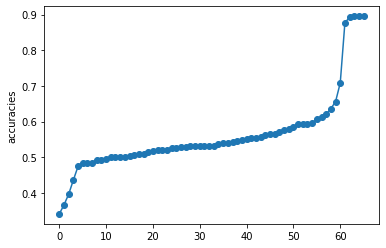

In [22]:
import matplotlib.pyplot as plt

plt.plot(temp)
plt.scatter(range(len(temp)),temp)
plt.ylabel('accuracies')
plt.show()